In [48]:
# Import the NumPy
import numpy as np

# Import the 'optimize' module from SciPy
import scipy.optimize

# Importing plt from matplotlib.pyplot
import matplotlib.pyplot as plt

### Unpack Function ###
Function to unpack a single vector of weights into weight matrices and bias vectors for a multi-layer neural network.
    
Arguments:
- weights: Flattened array containing all weights and biases.
- NUM_HIDDEN_LAYERS: Number of hidden layers in the neural network.
- NUM_INPUT: Number of input features.
- NUM_HIDDEN: List specifying the number of units in each hidden layer.
- NUM_OUTPUT: Number of output units.

Returns:
- Ws: List of weight matrices for each layer.
- bs: List of bias vectors for each layer.

In [17]:
def unpack(weights, NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT):
    
    # Initialize list to store weight matrices
    Ws = []

    # Unpack the weight matrix for the input layer to the first hidden layer
    start = 0
    end = NUM_INPUT * NUM_HIDDEN[0]  # Calculate the range for the first weight matrix
    W = weights[start:end]  # Slice the weight vector for the first layer's weights
    Ws.append(W)  # Append the weight vector to the list

    # Unpack weight matrices between hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):  # Loop through hidden layers
        start = end  # Update the start index
        end = end + NUM_HIDDEN[i] * NUM_HIDDEN[i+1]  # Calculate the end index for the next layer
        W = weights[start:end]  # Slice the weight vector for the current layer's weights
        Ws.append(W)  # Append the weight vector to the list

    # Unpack the weight matrix for the last hidden layer to the output layer
    start = end  # Update the start index for the last layer
    end = end + NUM_HIDDEN[-1] * NUM_OUTPUT  # Calculate the end index for the output layer
    W = weights[start:end]  # Slice the weight vector for the output layer's weights
    Ws.append(W)  # Append the weight vector to the list

    # Reshape the weight vectors into matrices for each layer
    Ws[0] = Ws[0].reshape(NUM_HIDDEN[0], NUM_INPUT)  # Reshape the first layer (input to hidden)
    for i in range(1, NUM_HIDDEN_LAYERS):  # Loop through hidden layers
        Ws[i] = Ws[i].reshape(NUM_HIDDEN[i], NUM_HIDDEN[i-1])  # Reshape the hidden-to-hidden weights
    Ws[-1] = Ws[-1].reshape(NUM_OUTPUT, NUM_HIDDEN[-1])  # Reshape the final layer (hidden to output)

    # Initialize list to store bias vectors
    bs = []

    # Unpack bias vector for the first hidden layer
    start = end  # Set start index for biases
    end = end + NUM_HIDDEN[0]  # Calculate the end index for the first bias vector
    b = weights[start:end]  # Slice the weight vector for the biases
    bs.append(b)  # Append the bias vector to the list

    # Unpack bias vectors for the hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):  # Loop through hidden layers
        start = end  # Update the start index for the next bias vector
        end = end + NUM_HIDDEN[i+1]  # Calculate the end index for the next bias vector
        b = weights[start:end]  # Slice the weight vector for the biases
        bs.append(b)  # Append the bias vector to the list

    # Unpack the bias vector for the output layer
    start = end  # Set start index for the output layer's bias
    end = end + NUM_OUTPUT  # Calculate the end index for the output layer's bias vector
    b = weights[start:end]  # Slice the weight vector for the biases
    bs.append(b)  # Append the bias vector to the list

    # Return the unpacked weight matrices and bias vectors
    return Ws, bs

### Initializing the weights and biases

Initializes the weights and biases for a multi-layer neural network using a modified Kaiming He Uniform initialization for weights and a small constant for biases.
    
Arguments:
- NUM_HIDDEN_LAYERS: Number of hidden layers in the neural network.
- NUM_INPUT: Number of input features.
- NUM_HIDDEN: List specifying the number of units in each hidden layer.
- NUM_OUTPUT: Number of output units.

Returns:
- Ws: List of initialized weight matrices.
- bs: List of initialized bias vectors.

In [18]:
def initWeightsAndBiases(NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT):
    
    Ws = []  # List to store weight matrices
    bs = []  # List to store bias vectors

    # Strategy:
    # - Weight initialization: Kaiming He Uniform initialization, suitable for ReLU activation functions.
    # - Bias initialization: Small positive constant (0.01).

    # Set random seed for reproducibility
    np.random.seed(0)

    # Initialize weights between input layer and the first hidden layer
    W = 2 * (np.random.random(size=(NUM_HIDDEN[0], NUM_INPUT)).astype(np.float32) / NUM_INPUT**0.5) - 1./NUM_INPUT**0.5
    Ws.append(W)  # Add the initialized weight matrix to the list
    
    # Initialize biases for the first hidden layer
    b = 0.01 * np.ones(NUM_HIDDEN[0], dtype=np.float32)  # Bias initialized to a small positive number (0.01)
    bs.append(b)  # Add the initialized bias vector to the list

    # Initialize weights and biases for hidden layers
    for i in range(NUM_HIDDEN_LAYERS - 1):
        # Initialize weights between the ith hidden layer and the next hidden layer
        W = 2 * (np.random.random(size=(NUM_HIDDEN[i+1], NUM_HIDDEN[i])).astype(np.float32) / NUM_HIDDEN[i]**0.5) - 1./NUM_HIDDEN[i]**0.5
        Ws.append(W)  # Add the weight matrix to the list
        
        # Initialize biases for the next hidden layer
        b = 0.01 * np.ones(NUM_HIDDEN[i+1], dtype=np.float32)  # Bias initialized to 0.01
        bs.append(b)  # Add the bias vector to the list

    # Initialize weights for the final output layer (from last hidden layer to output)
    W = 2 * (np.random.random(size=(NUM_OUTPUT, NUM_HIDDEN[-1])).astype(np.float32) / NUM_HIDDEN[-1]**0.5) - 1./NUM_HIDDEN[-1]**0.5
    Ws.append(W)  # Add the weight matrix to the list
    
    # Initialize biases for the output layer
    b = 0.01 * np.ones(NUM_OUTPUT, dtype=np.float32)  # Bias initialized to 0.01
    bs.append(b)  # Add the bias vector to the list

    # Return the lists of weight matrices and bias vectors
    return Ws, bs


In [27]:
# Helper functions

def relu(z):
    
    return np.maximum(0, z)

def relu_derivative(z):
        return (z > 0).astype(float)
    
def softmax(Z):
    # to avoid large exponent values, we will use the deviation idealogy of subtracting each value with the max value , thereby keeping the order preserved and since it will be normalised , result wont matter
    
    exponent_z = np.exp(Z - np.max(Z,axis=1,keepdims=True))
    
    prediction = exponent_z/(np.sum(exponent_z,axis=1,keepdims=True))
    
    return prediction


def fCE (X, Y, weights):
    Ws, bs = unpack(weights)
    H_activation,_= forward_pass(X,Ws,bs,NUM_HIDDEN_LAYERS)
    y_pred = H_activation[-1]
    ce = loss(Y,y_pred,Ws,0)
    return ce

def gradCE(X, Y, weights):
    # Unpack the flattened weights and biases
    Ws, bs = unpack(weights)
    
    wt_grad = []  # List to store weight gradients
    bi_grad = []  # List to store bias gradients

    # Perform a forward pass through the network
    H_activation, z_score = forward_pass(X, Ws, bs, NUM_HIDDEN_LAYERS)
    
    # Initialize one-hot encoded labels (y_onehot)
    y_onehot = np.zeros_like(H_activation[-1])
    
    # Convert Y to integer type if needed
    Y = Y.astype(int)
    
    # One-hot encode the ground truth labels
    y_onehot[np.arange(len(Y)), Y] = 1

    # Compute the gradient of the loss w.r.t. the output layer (softmax layer)
    g = H_activation[-1] - y_onehot  # Difference between prediction and ground truth
    
    # Backpropagate through each layer, starting from the output layer
    for i in range(NUM_HIDDEN_LAYERS, -1, -1):
        # Gradient of weights (g^T * H) and biases (sum of gradients over batch size)
        grad_wt = np.dot(g.T, H_activation[i]) / len(Y)
        grad_bi = np.sum(g, axis=0, keepdims=True) / len(Y)
        
        # Append the computed gradients to the respective lists
        wt_grad.append(grad_wt)
        bi_grad.append(grad_bi)
        
        if i > 0:  # If not the first layer (input layer)
            # Backpropagate the gradient to the previous layer using the ReLU derivative
            g = np.dot(g, Ws[i]) * relu_derivative(z_score[i-1])
    
    # Reverse the gradients list so they align correctly with the weight matrices
    wt_grad.reverse()
    bi_grad.reverse()

    # Flatten and concatenate all gradients (weights and biases) into a single vector
    allGradientsAsVector = np.hstack([W.flatten() for W in wt_grad] + [b.flatten() for b in bi_grad])
    
    return allGradientsAsVector


### Loss Function ###

Computes the cross-entropy loss between the true labels (y_label) and the predicted
probabilities (y_pred) for a batch of data. Optionally, it also supports L2 regularization.

Arguments:
- y_label: Ground truth labels (as integer indices).
- y_pred: Predicted probabilities from the softmax function.
- W: Weight matrix (used for optional L2 regularization, currently not used).
- alpha: Regularization parameter (L2 regularization strength, currently not used).

Returns:
- loss: The average cross-entropy loss for the batch.

In [28]:
def loss(y_label, y_pred, W, alpha):

    # Get the batch size, i.e., number of samples in the current batch.
    batch_s = y_label.shape[0]  # This ensures loss is computed as an average across the batch.

    # Ensure that y_label is of integer type, as it represents class indices.
    y_label = y_label.astype(int)

    # Compute the negative log-likelihood (cross-entropy loss) for the true class labels.
    # For each sample, we access the predicted probability for the true label.
    prob = -np.log(y_pred[range(batch_s), y_label])  # Select the predicted probability for the true label using indexing.
    
    # Compute the total loss by summing all the individual losses, and then averaging over the batch.
    loss = np.sum(prob) / batch_s  # Average loss across the batch.
    
    # Optionally, L2 regularization (currently commented out).
    # It penalizes large weights to prevent overfitting, and helps to smooth the loss landscape.
    # reg_loss = alpha / 2 * np.sum(np.square(W))  # L2 regularization term (currently not used).
    
    # Compute total batch loss (currently not using regularization).
    # batch_loss = loss + reg_loss  # Total loss (including regularization).
    
    return loss  # Return the average cross-entropy loss (without regularization).


### Forward Pass

Performs the forward pass through a neural network, computing activations for each layer.

Arguments:
- x: Input data (batch of samples).
- Weights: List of weight matrices for each layer.
- bias: List of bias vectors for each layer.
- NUM_HIDDEN_LAYERS: Number of hidden layers in the network.

Returns:
- H_activation: A list containing the activations for each layer (including input and output layers).
- z_preactivation_score: A list containing the pre-activation scores (z values) for each layer.

In [29]:
def forward_pass(x, Weights, bias, NUM_HIDDEN_LAYERS):
    
    z_preactivation_score = []  # To store the pre-activation (z) values for each layer.
    H_activation = [x]  # List to store activations, starting with the input data (H0 = x).
    
    # Loop over each hidden layer to compute pre-activations (z) and activations (H).
    for i in range(NUM_HIDDEN_LAYERS):
        # Compute the pre-activation score for the i-th layer: z = H_prev * W.T + b
        z = np.dot(H_activation[-1], Weights[i].T) + bias[i]
        
        # Store the pre-activation score (before applying the activation function).
        z_preactivation_score.append(z)
        
        # Apply the ReLU activation function to the pre-activation score to get the next activation.
        H = relu(z)
        
        # Append the activation (H) to the list of activations.
        H_activation.append(H)
    
    # For the output layer (final layer), apply softmax to get predicted probabilities (y_pred).
    z = np.dot(H_activation[-1], Weights[-1].T) + bias[-1]  # Pre-activation for the output layer.
    
    # Store the pre-activation score for the output layer.
    z_preactivation_score.append(z)
    
    # Apply softmax to the final pre-activation score to compute the predicted probabilities (output).
    y_pred = softmax(z)
    
    # Append the output layer activation (y_pred) to the list of activations.
    H_activation.append(y_pred)
    
    # Return both the activations and the pre-activation scores for each layer.
    return H_activation, z_preactivation_score

### Back Propogation

Performs the backpropagation algorithm to compute gradients and update weights and biases
using gradient descent with L2 regularization.

Arguments:
- x_batch: Batch of input data.
- y_batch: Batch of true labels (ground truth).
- h_activations: List of activations from the forward pass (including input and output).
- z_score: List of pre-activation scores (z values) from the forward pass.
- Weights: List of weight matrices for each layer.
- bias: List of bias vectors for each layer.
- lr: Learning rate for gradient descent.
- alpha: L2 regularization strength.
- NUM_HIDDEN_LAYERS: Number of hidden layers in the neural network.

Returns:
- Weights: Updated weight matrices after gradient descent.
- bias: Updated bias vectors after gradient descent.

In [30]:
def backprop(x_batch, y_batch, h_activations, z_score, Weights, bias, lr, alpha, NUM_HIDDEN_LAYERS):
    
    wt_gradient = []  # To store gradients for weight matrices
    bias_gradient = []  # To store gradients for bias vectors
    batch_s = y_batch.shape[0]  # Get the batch size
    
    # Create a one-hot encoded matrix for the ground truth labels
    y_onehot = np.zeros_like(h_activations[-1])  # Shape is same as the output layer (y_pred)
    y_onehot[np.arange(batch_s), y_batch] = 1  # Set the correct label index for each sample in the batch

    # Compute the initial gradient of the loss with respect to the output (y_pred)
    g = h_activations[-1] - y_onehot  # Gradient of cross-entropy loss w.r.t. output (softmax layer)

    # Loop over each layer, starting from the output layer and going backward
    for i in range(NUM_HIDDEN_LAYERS, -1, -1):
        # Compute the gradient of the weight matrix for the current layer
        grad_wt = np.dot(g.T, h_activations[i]) / batch_s  # Divide by batch size for averaging
        grad_bi = np.sum(g, axis=0, keepdims=True) / batch_s  # Compute gradient of the bias vector
        
        # Store the gradients for later use
        wt_gradient.append(grad_wt)
        bias_gradient.append(grad_bi)
        
        # Propagate the gradient to the previous layer (if not the input layer)
        if i > 0:
            g = np.dot(g, Weights[i]) * relu_derivative(z_score[i - 1])  # Chain rule application
            
    # Reverse the gradients list to maintain the correct order (from first layer to last)
    wt_gradient.reverse()
    bias_gradient.reverse()

    # Gradient descent update step for weights and biases
    for i in range(NUM_HIDDEN_LAYERS + 1):
        # Update weights using gradient descent and L2 regularization (alpha * Weights[i])
        Weights[i] -= lr * (wt_gradient[i] + alpha * Weights[i])
        # Update bias using gradient descent
        bias[i] -= lr * bias_gradient[i].reshape(-1)
    
    return Weights, bias  # Return the updated weights and biases

### Train Function

Train the neural network using stochastic gradient descent (SGD) with mini-batches.

Arguments:
- X_train: Training data inputs (features).
- y_train: Training data labels (targets).
- weights: Initial flattened weights and biases (single vector).
- X_val: Validation data inputs (optional for validation purposes).
- y_val: Validation data labels (optional for validation purposes).
- lr: Learning rate for gradient descent.
- num_epochs: Number of training epochs.
- batch_size: Size of mini-batches for SGD.
- alpha: L2 regularization strength.
- NUM_HIDDEN_LAYERS: Number of hidden layers in the neural network.
- NUM_INPUT: Number of input features (size of input layer).
- NUM_HIDDEN: List of sizes for each hidden layer.
- NUM_OUTPUT: Number of output classes (size of output layer).

Returns:
- WTS: Flattened final weights and biases after training.
- avg_loss: Average loss over all epochs.

In [40]:
def train(X_train, y_train, weights, X_val, y_val, lr, num_epochs, batch_size, alpha, NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT):
    
    num_tr_samples = X_train.shape[0]  # Total number of training samples
    tr_indices = np.arange(num_tr_samples)  # Create an array of sample indices for shuffling

    # Unpack the initial weights and biases from the flattened vector
    Weights, bias = unpack(weights, NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT)
    
    total_loss = 0  # Initialize total loss accumulator

    # Training loop for multiple epochs
    for epoch in range(num_epochs):
        np.random.shuffle(tr_indices)  # Shuffle the training sample indices at the start of each epoch
        
        # Iterate over mini-batches
        for num in range(0, num_tr_samples, batch_size):
            # Select a mini-batch of data based on the current indices
            batch_index = tr_indices[num: num + batch_size]
            x_batch = X_train[batch_index]  # Extract the inputs for the mini-batch
            y_batch = y_train[batch_index]  # Extract the labels for the mini-batch
            
            # Perform a forward pass to compute activations and pre-activations
            H_activations, z_list = forward_pass(x_batch, Weights, bias, NUM_HIDDEN_LAYERS)
   
            # Perform backpropagation and update weights and biases
            Weights, bias = backprop(x_batch, y_batch, H_activations, z_list, Weights, bias, lr, alpha, NUM_HIDDEN_LAYERS)
        
        # After each epoch, calculate the loss for the entire training set
        activations, _ = forward_pass(X_train, Weights, bias, NUM_HIDDEN_LAYERS)
        epoch_loss = loss(y_train, activations[-1], Weights, alpha)  # Compute the loss after one epoch
        
        total_loss += epoch_loss  # Accumulate the total loss over epochs

    # After training, flatten the final weights and biases into a single vector
    WTS = np.hstack([W.flatten() for W in Weights] + [b.flatten() for b in bias])
    
    # Calculate the average loss over all epochs
    avg_loss = total_loss / num_epochs
    
    return WTS, avg_loss  # Return the final weights and average loss


### Validate Function

Validate the performance of the neural network on a validation dataset.

Arguments:
- X_val: Validation data inputs (features).
- y_val: Validation data labels (targets).
- weights: Current weights and biases of the model (flattened vector).
- NUM_HIDDEN_LAYERS: Number of hidden layers in the neural network.
- NUM_INPUT: Number of input features (size of input layer).
- NUM_HIDDEN: List of sizes for each hidden layer.
- NUM_OUTPUT: Number of output classes (size of output layer).

Returns:
- accuracy: The accuracy of the model on the validation dataset (fraction of correct predictions).

In [41]:
def validate(X_val, y_val, weights, NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT):
    
    # Unpack the weights and biases from the flattened weights vector
    Weights, bias = unpack(weights, NUM_HIDDEN_LAYERS, NUM_INPUT, NUM_HIDDEN, NUM_OUTPUT)
    
    # Perform forward pass on the validation data to compute activations
    activations, _ = forward_pass(X_val, Weights, bias, NUM_HIDDEN_LAYERS)
    
    # The last element of activations corresponds to the output layer predictions
    y_pred = activations[-1]

    # Get the predicted class labels by taking the index of the maximum predicted probability
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    # Calculate the accuracy by comparing predicted labels with the true labels
    accuracy = np.mean(y_pred_labels == y_val)  # Fraction of correct predictions
    
    # Optionally print the validation accuracy (commented out)
    # print(f'Validation accuracy: {accuracy * 100:.2f}%')
    
    return accuracy  # Return the computed accuracy

In [42]:
def test(X_test, y_test, weights, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT):
    
    Weights, bias = unpack(weights,NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)
    # Perform forward pass on validation data
    activations, _ = forward_pass(X_test, Weights, bias, NUM_HIDDEN_LAYERS)
    
    # Assuming the last activation is the output layer
    y_pred = activations[-1]

    y_pred_labels = np.argmax(y_pred, axis=1)
    

    # Calculate accuracy
    accuracy = np.mean(y_pred_labels == y_test)
#     print(f'Test accuracy: {accuracy * 100:.2f}%')
    
    return accuracy

In [44]:
if __name__ == "__main__":
    # Load training data.
    # Recommendation: divide the pixels by 255 (so that their range is [0-1]), and then subtract
    # 0.5 (so that the range is [-0.5,+0.5]).
    
    NUM_HIDDEN_LAYERS = 3
    NUM_INPUT = 784
    NUM_HIDDEN = NUM_HIDDEN_LAYERS * [ 64 ]  # you can customise here
    NUM_OUTPUT = 10

    training_data = np.reshape(np.load("fashion_mnist_train_images.npy"), (-1, 28*28))
    training_labels = np.load("fashion_mnist_train_labels.npy")
    
    num_datapoints = training_data.shape[0]
    split_index = int(0.8*num_datapoints)
    indices = np.arange(num_datapoints)
    np.random.shuffle(indices)

    train_indices = indices[:split_index]
    val_indices = indices[split_index:]

    X_train, X_val = training_data[train_indices], training_data[val_indices]   
    y_train, y_val = training_labels[train_indices], training_labels[val_indices]

    X_train = X_train / 255.0 - 0.5
    X_val = X_val / 255.0 - 0.5

    testing_data = np.reshape(np.load("fashion_mnist_test_images.npy"), (-1, 28*28))
    testing_labels= np.load("fashion_mnist_test_labels.npy")
    
    X_test = testing_data
    y_test = testing_labels
    X_test = X_test / 255.0 - 0.5
    
#     num_epochs = 100
#     batch_size =64
#     alpha =0.0
#     lr = 0.01
    
    
    num_epochs = 10
    batch_size = 8
    alpha = 0.0
    lr = 0.01
    
    
    Ws, bs = initWeightsAndBiases(NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)
    weights = np.hstack([ W.flatten() for W in Ws ] + [ b.flatten() for b in bs ])
    weights = weights.astype(np.float32)
    
    trainX, trainY = X_train[:5].astype(np.float32), y_train[:5].astype(np.float32)
    
    print(scipy.optimize.check_grad(
        lambda weights_: fCE(trainX, trainY, weights_,NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT),  # No slicing on trainX
        lambda weights_: gradCE(trainX, trainY, weights_, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT),
        weights
    ))
    
    weights, avg_loss = train(X_train, y_train, weights, X_val, y_val, lr,num_epochs,batch_size,alpha,NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)  # we get optimised weights
    val_accuracy = validate(X_val, y_val, weights, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)
    test_accuracy = test(X_test, y_test, weights, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)
    

    print(scipy.optimize.approx_fprime(weights, lambda weights_: fCE(trainX, trainY, weights_, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT), 1e-6))

3.5305727448724214e-06
[-1.48039360e-02 -1.48039360e-02 -1.49787697e-02 ...  1.41575085e-04
  8.76898554e-06 -1.38318246e-04]


### Part(B)

**Check_grad weights**

The output for these weights is saved in a text file named **"Part_B_check_grad_weights.txt"**. 

In [47]:
with open("output.txt", "w") as file:
    # Gradient check using check_grad
    grad_check = scipy.optimize.check_grad(
        lambda weights_: fCE(trainX, trainY, weights_, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT),  # Loss function
        lambda weights_: gradCE(trainX, trainY, weights_, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT),  # Gradient of the loss
        weights  # Initial weights
    )
    file.write(f"Gradient check using check_grad: {grad_check}\n\n")
    
    # Gradient check using approx_fprime
    approx_grad = scipy.optimize.approx_fprime(weights, lambda weights_: fCE(trainX, trainY, weights_, NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT), 1e-6)
    
    # Write each value of the approx_fprime output on a new line
    file.write("Gradient check using approx_fprime:\n")
    for i, value in enumerate(approx_grad):
        file.write(f"Value {i}: {value}\n")

In [32]:
# Next we will perform hyperparameter tuning
# performed iterations around 162 for different hyperparameters

In [33]:
# Next lets test our model with our best weights and hyperparameters
test_weights = np.load("best_model_weights_bp.npy")
test_hyp = np.load("best_model_hyperparameters_bp.npy", allow_pickle=True)


In [34]:
testing_data = np.reshape(np.load("fashion_mnist_test_images.npy"), (-1, 28*28))
testing_labels= np.load("fashion_mnist_test_labels.npy")

X_test = testing_data
y_test = testing_labels
X_test = X_test / 255.0 - 0.5

num_input = 784
num_output = 10
hyperparameters = test_hyp.item()
num_hidden_layers = hyperparameters['num_hidden_layers']
num_hidden_units = hyperparameters['num_hidden_units']
num_epochs = hyperparameters['num_epochs']
learning_rate = hyperparameters['learning_rate']
mini_batch = hyperparameters['mini_batch']

num_hidden = num_hidden_layers * [num_hidden_units]

Best_test_accuracy = test(X_test, y_test, test_weights, num_hidden_layers,num_input,num_hidden,num_output)


In [44]:
def show_W0 (W,NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT):
    Ws,bs = unpack(W,NUM_HIDDEN_LAYERS,NUM_INPUT,NUM_HIDDEN,NUM_OUTPUT)
    W = Ws[0]
    n = int(NUM_HIDDEN[0] ** 0.5)
    # plt.imshow(np.vstack([
    #     np.hstack([ np.pad(np.reshape(W[idx1*n + idx2,:], [ 28, 28 ]), 2, mode='constant') for idx2 in range(n) ]) for idx1 in range(n)
    # ]), cmap='gray')

    image_grid = np.vstack([
    np.hstack([ 
        np.pad(np.reshape(W[idx1 * n + idx2, :], [28, 28]), 2, mode='constant') 
        for idx2 in range(n) 
    ]) 
    for idx1 in range(n)])

    # plt.show()
    
    fig, ax = plt.subplots()
    ax.imshow(image_grid, cmap='gray')
    
    fig.savefig('weight_photo.png', dpi=300, bbox_inches = 'tight')

    plt.show()
 

### Part (D)

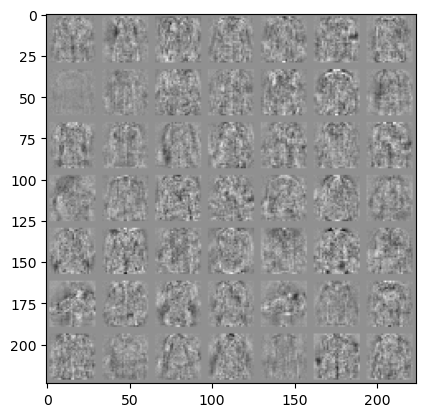

In [45]:
show_W0(test_weights,num_hidden_layers,num_input,num_hidden,num_output)